In [1]:
import pie
import numpy as np
import scipy
import matplotlib.pyplot as plt
import skimage as ski
from typing import Union, Optional, Tuple
from pathlib import Path
import time

In [2]:
def divergent_plot(mat, vmin=None, vmax=None, title=None):
  """
  Plot the image with a divergent palette and a colorbar
  """
  if vmin is None or vmax is None:
      vmax = np.abs(mat).max()
      vmin = -vmax

  if title:
     plt.title(title)
  plt.imshow(mat, cmap="bwr", vmin=vmin, vmax=vmax)

  plt.xticks(np.arange(0, mat.shape[1], 5))
  plt.yticks(np.arange(0, mat.shape[0], 5))

  plt.colorbar()
  plt.show()


def composite(
  src_uri: Union[Path, str], 
  tgt_uri: Union[Path, str], 
  mask_uri: Optional[Union[Path, str]] = None,
  *,
  tgt_offset: Optional[Tuple[int, int]] = None,
  show_plot: bool = True,
  save_results: bool = True,
  results_dir: Union[Path, str] = "./results/"
) -> Tuple[np.ndarray, np.ndarray]:
  
  if tgt_offset is None:
    tgt_offset = (0, 0)

  src_uri = Path(src_uri)
  tgt_uri = Path(tgt_uri)

  src = ski.io.imread(src_uri) / 255.0
  tgt = ski.io.imread(tgt_uri) / 255.0

  assert src.ndim == tgt.ndim == 3
  
  if mask_uri is not None:
    mask = ski.io.imread(mask_uri).astype(np.bool) 
  else:
    mask = np.ones(src.shape[:2], dtype=np.bool)
    mask[[0, -1], :] = False
    mask[:, [0, -1]] = False

  assert mask.ndim == 2

  composite_base = pie.poisson_compositing_wrapper(src, tgt, mask, tgt_offset=tgt_offset, mixing=False)
  composite_mixing = pie.poisson_compositing_wrapper(src, tgt, mask, tgt_offset=tgt_offset, mixing=True)

  if save_results:
    results_dir = Path(results_dir)
    if not results_dir.exists():
        results_dir.mkdir()
        print(f"Folder '{results_dir}' created.")
    ski.io.imsave(results_dir / f"composite_base_{src_uri.stem}_{tgt_uri.stem}_{int(time.time())}.png", (composite_base*255).astype(np.uint8))
    ski.io.imsave(results_dir / f"composite_mixing_{src_uri.stem}_{tgt_uri.stem}_{int(time.time())}.png", (composite_mixing*255).astype(np.uint8))

  if show_plot:
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 15), sharex=False, sharey=False)

    for ax in axs.flat:
        ax.axis('off')

    axs[0].set_title('Source')
    axs[0].imshow(src)

    axs[1].set_title('Source Mask')
    axs[1].imshow((mask*255).astype(np.uint8), cmap="gray")

    axs[2].set_title('Target')
    axs[2].imshow(tgt)

    axs[3].set_title('Composite (Poisson)')
    axs[3].imshow(composite_base)

    axs[4].set_title('Composite (Poisson Mixing Gradients)')
    axs[4].imshow(composite_mixing)

    plt.show()

  return composite_base, composite_mixing

## Results

Folder 'results' created.


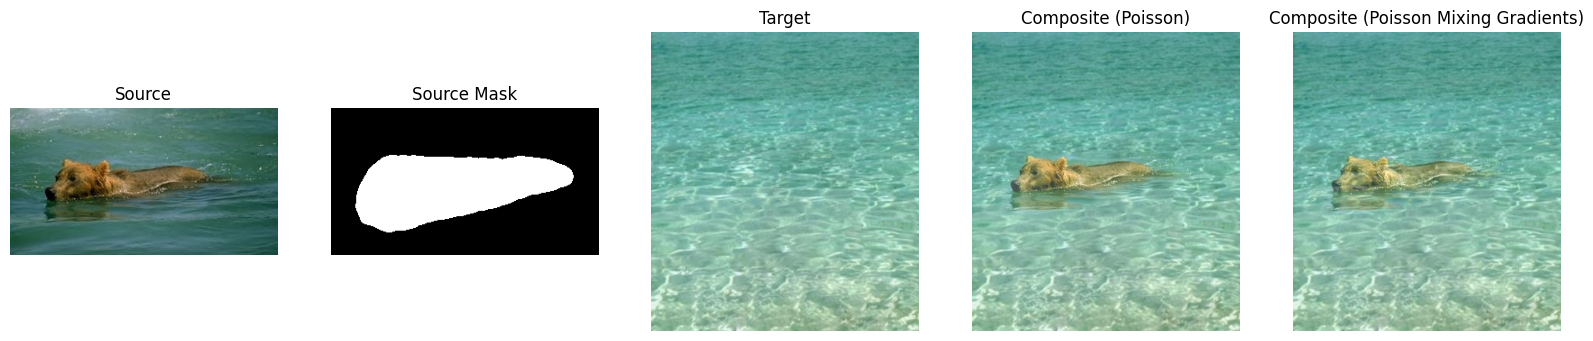

In [3]:
_ = composite(src_uri="img/bear.jpg", tgt_uri="img/water.jpg", mask_uri="img/bear_mask.png", 
              tgt_offset=(100, 10), show_plot=True, save_results=True)

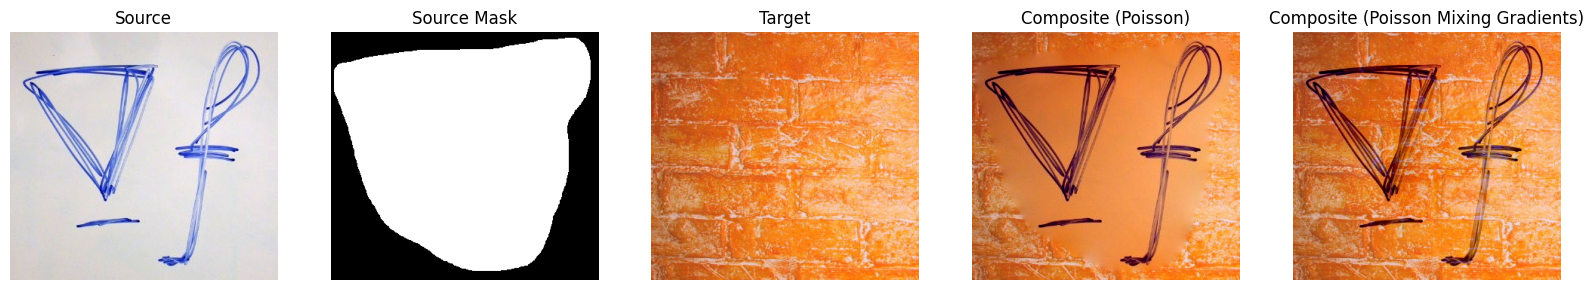

In [4]:
_ = composite(src_uri="img/equation.jpg", tgt_uri="img/wall.jpg", mask_uri="img/equation_mask.png", 
              show_plot=True, save_results=True)

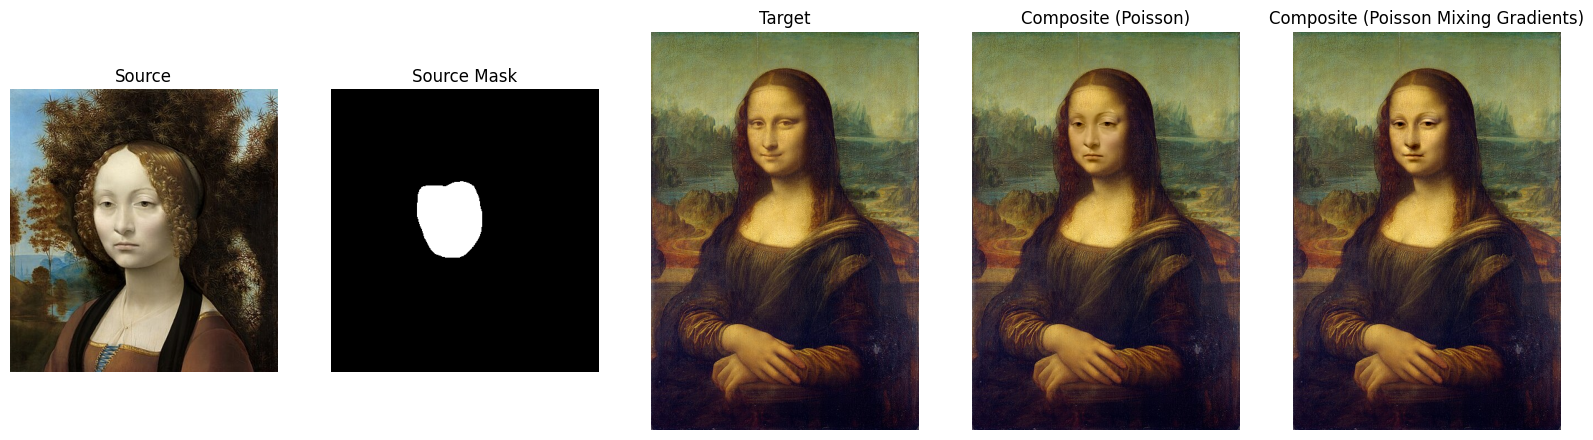

In [5]:
_ = composite(src_uri="img/ginevra.jpg", tgt_uri="img/monalisa.jpg", mask_uri="img/ginevra_mask.png", 
              tgt_offset=(7, 56), show_plot=True, save_results=True)

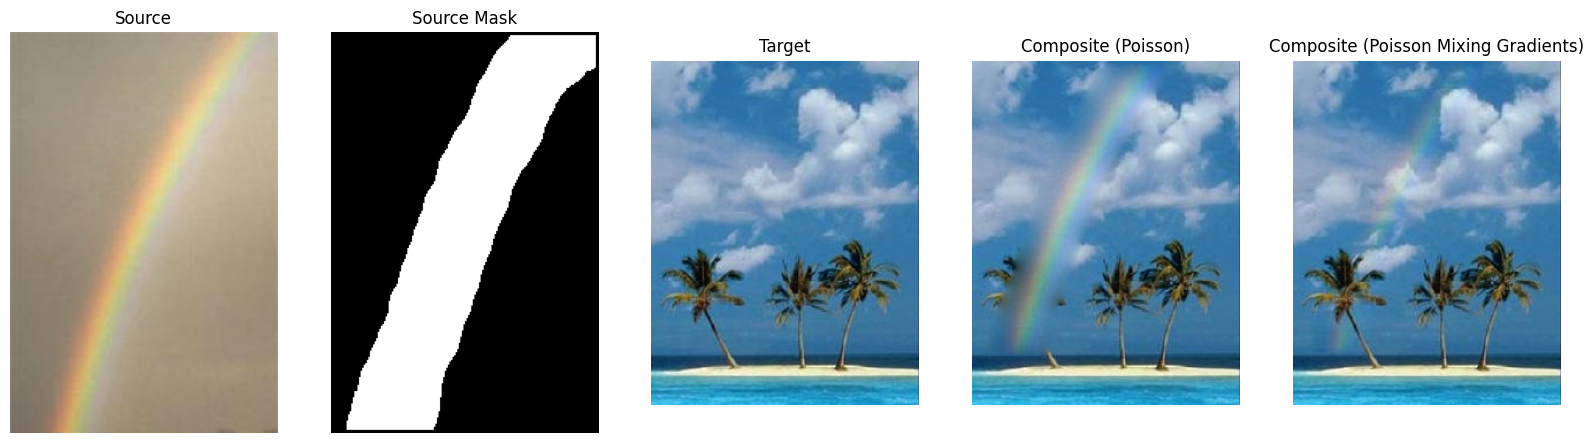

In [6]:
_ = composite(src_uri="img/rainbow.jpg", tgt_uri="img/isle.jpg", mask_uri="img/rainbow_mask.png", 
              show_plot=True, save_results=True)

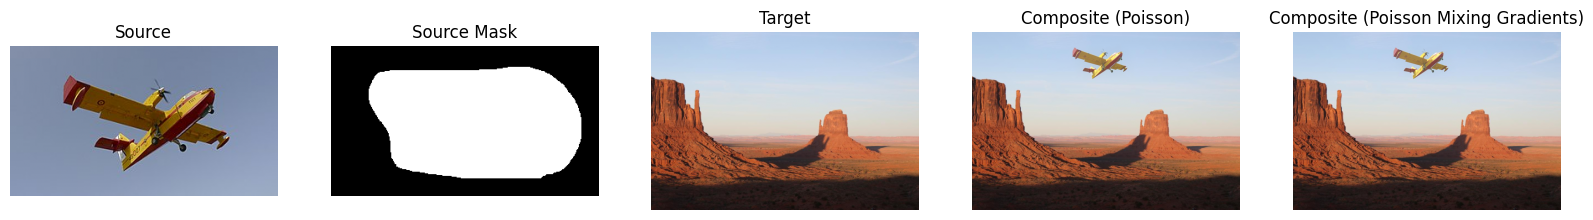

In [7]:
_ = composite(src_uri="img/canadair.jpg", tgt_uri="img/valley.jpg", mask_uri="img/canadair_mask.png", 
              tgt_offset=(20, 300), show_plot=True, save_results=True)

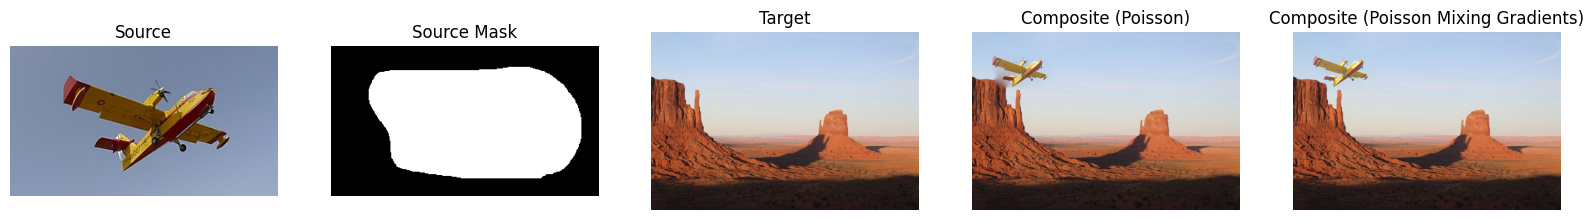

In [8]:
_ = composite(src_uri="img/canadair.jpg", tgt_uri="img/valley.jpg", mask_uri="img/canadair_mask.png", 
              tgt_offset=(50, 10), show_plot=True, save_results=True)

## Laplacian

In [9]:
im = ski.io.imread("img/house_small.png", as_gray=True)[3:22, :] / 255.0
L = pie.laplacian_matrix(im.shape[0], im.shape[1]).todense()
L_ = L.reshape(im.shape[0], im.shape[1], im.shape[0], im.shape[1])

([<matplotlib.axis.YTick at 0x2312b84a110>,
 [Text(0, 0, '0'), Text(0, 5, '5'), Text(0, 10, '10'), Text(0, 15, '15')])

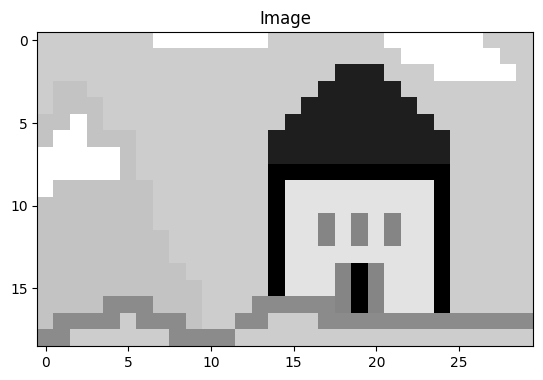

In [10]:
plt.imshow(im, cmap="gray")
plt.title(f"Image")
plt.xticks(np.arange(0, im.shape[1], 5))
plt.yticks(np.arange(0, im.shape[0], 5))

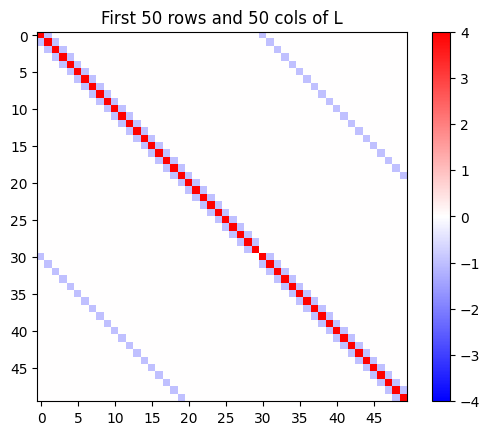

In [11]:
divergent_plot(L[:50, :50], title="First 50 rows and 50 cols of L")

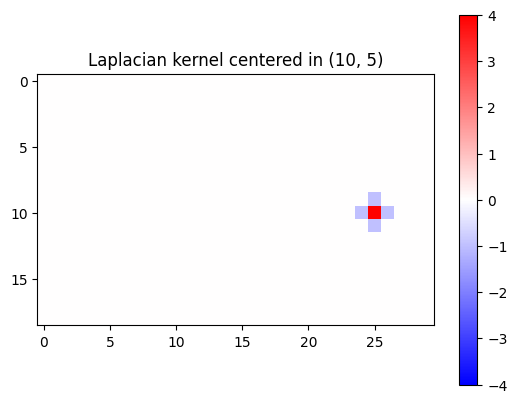

In [12]:
divergent_plot(L_[10, 25, :, :], title="Laplacian kernel centered in (10, 5)")

In [13]:
im = ski.io.imread("img/house_small.png", as_gray=True)[3:22, :]
L = pie.laplacian_matrix(im.shape[0], im.shape[1]).todense()
L_ = L.reshape(im.shape[0], im.shape[1], im.shape[0], im.shape[1])

In [14]:
im = ski.data.camera() / 255.0
L = pie.laplacian_matrix(im.shape[0], im.shape[1])
lapl1 = L.dot(im.reshape(im.shape[0]*im.shape[1])).reshape(im.shape)
ker = np.array(
    [[0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]]
)
lapl2 = scipy.signal.correlate2d(im, ker, mode="same")
print(np.allclose(lapl1, lapl2))

True


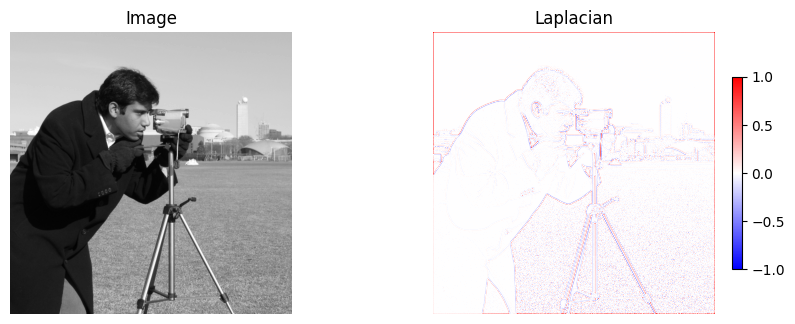

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for ax in axs.flat:
    ax.axis('off')

axs[0].set_title('Image')
temp = axs[0].imshow(im, cmap="gray")
plt.colorbar(temp, ax=axs[0], shrink=0.5).ax.set_visible(False)

axs[1].set_title('Laplacian')
temp = axs[1].imshow(lapl1, cmap="bwr", vmin=-np.abs(im).max(), vmax=np.abs(im).max())
plt.colorbar(temp, ax=axs[1], shrink=0.5)

plt.show()

***